# Day 08. Exercise 03
# Overfitting

## 0. Imports

In [201]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import joblib

## 1. Preprocessing

1. Read the file `dayofweek.csv` to a dataframe.
2. Using `train_test_split` with parameters `test_size=0.2`, `random_state=21` get `X_train`, `y_train`, `X_test`, `y_test`.
3. Using, for example, `value_counts()` to check if the distribution of classes is similar in train and test.
4. Use the additional parameter `stratify=` and check the distribution again, now it should be more or less similar in both datasets.

In [202]:
df = pd.read_csv('../data/dayofweek.csv')
df.head()

,numTrials,hour,dayofweek,uid_user_1,uid_user_10,uid_user_11,uid_user_12,uid_user_13,uid_user_14,uid_user_15,...,labname_lab02,labname_lab03,labname_lab03s,labname_lab05s,labname_laba04,labname_laba04s,labname_laba05,labname_laba06,labname_laba06s,labname_project1
0,-0.788667,-2.562352,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.756764,-2.562352,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.724861,-2.562352,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.692958,-2.562352,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.661055,-2.562352,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [203]:
X = df.drop('dayofweek', axis=1)
y = df['dayofweek']

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state=21)

In [205]:
y_train.value_counts()

dayofweek
3    313
6    287
1    222
5    216
2    125
0    105
4     80
Name: count, dtype: int64

In [206]:
y_test.value_counts()

dayofweek
3    83
6    69
5    55
1    52
0    31
4    24
2    24
Name: count, dtype: int64

Мы можем задать пропорцию классов при разделении на обучающий и проверяющий датасеты с помощью параметра stratify функции train_test_split. Стоит отметить, что мы будем стратифицировать в соответствии распределению по классам в y.

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state=21,
                                                    stratify=y)

In [208]:
y_train.value_counts()

dayofweek
3    316
6    285
1    219
5    217
2    119
0    109
4     83
Name: count, dtype: int64

In [209]:
y_test.value_counts()

dayofweek
3    80
6    71
1    55
5    54
2    30
0    27
4    21
Name: count, dtype: int64

## 2. Baseline models

1. Train exactly the same baseline models from the previous exercise and calculate the accuracies using the test dataset with stratification.
2. Did all the models show the similar values of the metric? Which one has the largest difference comparing the current exercise and the previous? Put the answer to the markdown cell in the end of the section.

### a. Logreg

In [210]:
logreg = LogisticRegression(random_state=21, fit_intercept=False)
logreg.fit(X_train, y_train)
prediction = logreg.predict(X_test)
accuracy_score(y_test, prediction)

0.6035502958579881

### b. SVM

In [211]:
svc = SVC(kernel='poly', probability=True, random_state=21)
svc.fit(X_train, y_train)
prediction = svc.predict(X_test)
accuracy_score(y_test, prediction)


0.8461538461538461

### c. Decision tree

In [212]:
model_tree = DecisionTreeClassifier(max_depth=15, random_state=21)
model_tree.fit(X_train, y_train)
prediction = model_tree.predict(X_test)
accuracy_score(y_test, prediction)

0.8284023668639053

### d. Random forest

In [213]:
model_forest = RandomForestClassifier(n_estimators=100,
                                      max_depth=25,
                                      random_state=21)
model_forest.fit(X_train, y_train)
prediction = model_forest.predict(X_test)
accuracy_score(y_test, prediction)

0.9230769230769231

Точность снизилась во всех случаях, кроме SVC (тут значительно выросла)

## 3. Crossvalidation

We could play with parameters of the model trying to achive a better accuracy on the test dataset, but it is a bad practice. It leads us again to overfitting. Test dataset is only for checking quality of a final model.

But there is another way of solving the problem – crossvalidation. It does not use test dataset, but creates one more split of train dataset. Again, there are different ways of doing it, but the common thing is that there is a validation dataset that is used for hyperparameters optimization.

1. Using `cross_val_score` with `cv=10` calculate the mean accuracy and standard deviation for every model that you used before (logreg with `solver='liblinear'`, SVC, decision tree, random forest).

### a. Logreg

In [214]:
logreg = LogisticRegression(random_state=21, fit_intercept=False, solver='liblinear')
scores = cross_val_score(logreg, X_train, y_train, cv=10)
print("Среднее значение точности:", scores.mean())
print("Стандартное отклонение:",scores.std())

Среднее значение точности: 0.5556550580431179
Стандартное отклонение: 0.027311158810936334


### b. SVM

In [215]:
svc = SVC(kernel='poly', probability=True, random_state=21)
scores = cross_val_score(svc, X_train, y_train, cv=10)
print("Среднее значение точности:", scores.mean())
print("Стандартное отклонение:",scores.std())

Среднее значение точности: 0.7944941956882257
Стандартное отклонение: 0.02623311767702464


### c. Decision tree

In [216]:
tree = DecisionTreeClassifier(max_depth=10, random_state=21)
scores = cross_val_score(tree, X_train, y_train, cv=10)
print("Среднее значение точности:", scores.mean())
print("Стандартное отклонение:",scores.std())

Среднее значение точности: 0.7284798231066888
Стандартное отклонение: 0.03656835539843546


### d. Random forest

In [217]:
forest = RandomForestClassifier(max_depth=25, n_estimators=100, random_state=21)
scores = cross_val_score(forest, X_train, y_train, cv=10)
print("Среднее значение точности:", scores.mean())
print("Стандартное отклонение:",scores.std())

Среднее значение точности: 0.9109729132117191
Стандартное отклонение: 0.01877860395269116


## 4. Optimization

1. Choose the best model and play a little bit with the parameters on cross-validation, find a good enough parameter or a combination of the parameters.
2. Calculate the accuracy for the final model on the test dataset.
3. Draw a plot that displays the top-10 most  important features for that model.
4. Save the model using `joblib`.
5. Load the model, make predictions for the test dataset and calculate the accuracy.

По результатам нашего исследования, можно сделать вывод, что наиболее удачной моделью для наших данных является RandomForestClassifier

In [218]:
model_random_forest = RandomForestClassifier(n_estimators=100,
                                             max_depth=25,
                                             random_state=21)
model_random_forest.fit(X_train, y_train)
prediction = model_random_forest.predict(X_test)
accuracy_score(y_test, prediction)

0.9230769230769231

In [219]:
scores = cross_val_score(forest, X_train, y_train, cv=10)
print("Среднее значение точности:", scores.mean())
print("Стандартное отклонение:",scores.std())

Среднее значение точности: 0.9109729132117191
Стандартное отклонение: 0.01877860395269116


In [220]:
def plot_features(coefs, features, n=10):

    coefs /= coefs.sum() 
    indices = coefs.argsort()[::-1][:n] 
    
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.barh(np.arange(n), coefs[indices])
    ax.set_yticks(np.arange(n))
    ax.set_yticklabels(features[indices])
    ax.invert_yaxis() 
    plt.show()

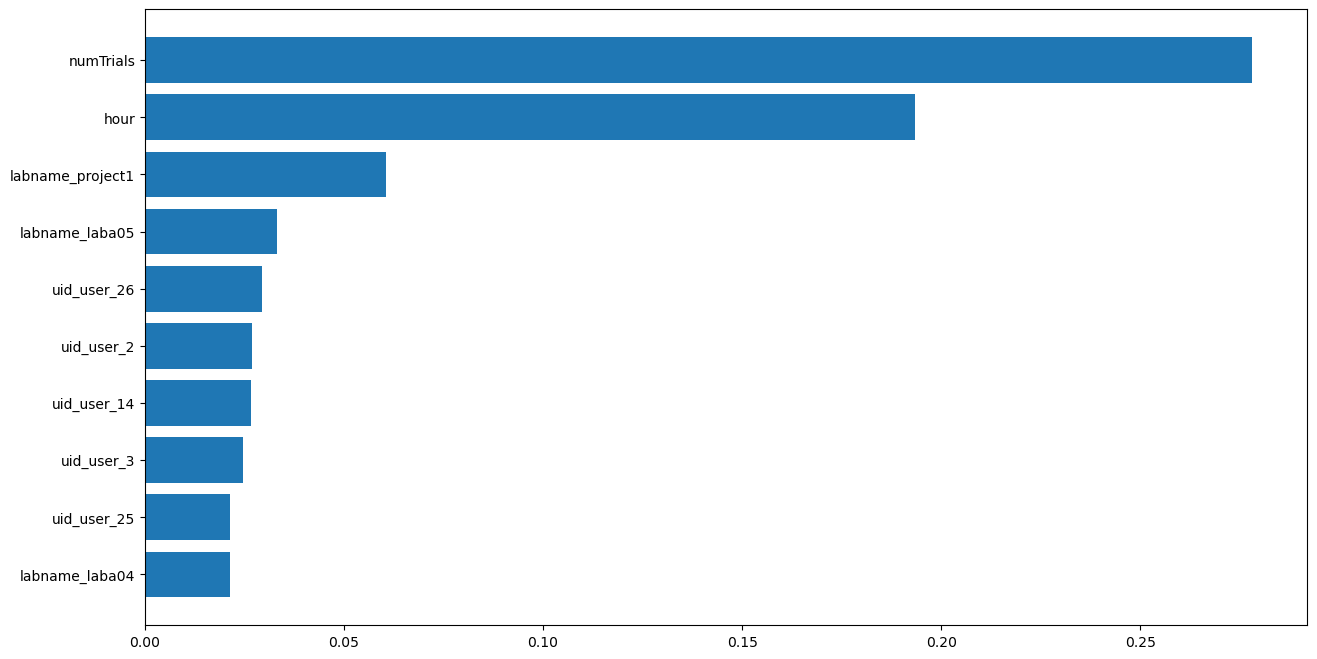

In [221]:
plot_features(model_random_forest.feature_importances_, X.columns)

In [222]:
joblib.dump(model_random_forest, 'model_random_forest.pkl')

['model_random_forest.pkl']

In [223]:
model = joblib.load('model_random_forest.pkl')
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9230769230769231